In [1]:
"""\
This script contains all the functions used to run pileup analyses in the paper
"Dynamics of microcompartment formation at the mitosis-to-G1 transition".

Example shows pileups generation for condensin depletion data (Fig. 4)

Uses cooltools: https://cooltools.readthedocs.io/en/latest/notebooks/pileup_CTCF.html

Author: Viraat Goel
"""

# If you are a developer, you may want to reload the packages on a fly.
# Jupyter has a magic for this particular purpose:
# %load_ext autoreload
# %autoreload 2

# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# import libraries for biological data analysis
import cooler
import bioframe

import cooltools

from packaging import version
#if version.parse(cooltools.__version__) < version.parse('0.5.2'):
#    raise AssertionError("tutorials rely on cooltools version 0.5.2 or higher,"+
#                         "please check your cooltools version and update to the latest")

### Set global parameters

In [3]:
# parameters
classification = 'exclusive' # 'inclusive' to cover all loops, 'exclusive' to exclude CRE (P-P, E-P, E-E) loops with CTCF
pad = 5000
res = 500
mask_radius_px = 10
region_extend = 100000

#List of mcool conditions as strings
conditions = ["0h", "0.5h", "1h", "4h", "8h"]

#Lists of mcool and cis-expected files
clrFiles = []
expectedFiles = []

for condition in conditions:
    clrFiles.append('COOLER_FILES_DIRECTORY/RCMC_Condensin_'+condition+'_mm39.merged.50.mcool')
    expectedFiles.append('EXPECTED_FILES_DIRECTORY/Condensin_'+condition+'_'+str(res)+'bpRes_mm39.tsv')

#List of loop types as strings
loopTypesNames = ["P-P", "E-P", "E-E", "EP-CTCF", "CTCF-CTCF", "P-CTCF", "E-CTCF", "all-other", "P-other", "E-other", "CTCF-other", "other-other"]

#List of loop file locations (bedpe)
loopFiles = []

for loopType in loopTypesNames:
    loopFiles.append('LOOPFILES_DIRECTORY'/'+loopType+'.bedpe')


#Specify the RCMC regions of the mcools to look at (format: chromosome (string), start (number), end (number), name of region (string))
regions = pd.DataFrame([['chr2',151920000,153000000,'Id1'],['chr8',84846629,85856629,'Klf1'],['chr8',122950000,124110000,'Cdt1'],['chr9',106675000,108600000,'Dag1'],['chr15',61810000,63684000,'Myc']],
                  columns=['chrom', 'start', 'end', 'name'])

#Set save directory
saveDir = 'SAVE_DIRECTORY/'

### Load in loop files

In [4]:
loop_dataframes = []

for loopFile in loopFiles:
    #load the list of called loops (bedpe)
    df_full = pd.read_csv(loopFile, sep='\t', header=None, index_col=None, names=('chrom1','start1','end1','chrom2','start2','end2'))
    df_full['mid1'] = (df_full['start1'] + df_full['end1']) // 2
    df_full['mid2'] = (df_full['start2'] + df_full['end2']) // 2

    df_temp = df_full.copy()
    df_temp['distance'] = df_temp['mid2'] - df_temp['mid1']
    df_distFilt = df_temp.loc[df_temp['distance'] > 12000] # drop the 58 loops that are <12kb in size since contact distances have to be at least double the size of the pad for the script to work
    df_distFilt.reset_index(drop=True, inplace=True)
    loop_dataframes.append(df_distFilt)

### Create pileups stack

In [ ]:
flankDist = 10_000
mtxsByConditionByType = []

for i in range(len(clrFiles)):
    clr = cooler.Cooler(f'{clrFiles[i]}::/resolutions/{res}')
    expected = pd.read_csv(expectedFiles[i], sep='\t', index_col=None)

    mtxsByType = []
    for j in range(len(loop_dataframes)):
        # create the stack of snips:
        stack = cooltools.pileup(clr, loop_dataframes[j], view_df=regions, expected_df=expected, flank=flankDist)
        mtx = np.nanmean(stack, axis=2)
        mtxsByType.append(mtx)
    
    mtxsByConditionByType.append(mtxsByType)

### Visualize single pileup to confirm parameters

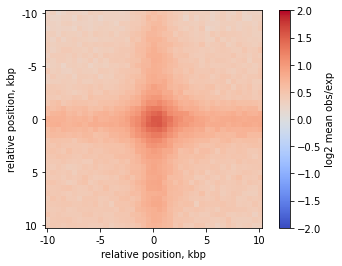

In [6]:
plt.imshow(
    np.log2(mtxsByConditionByType[0][0]),
    vmax = 2,
    vmin = -2,
    cmap='coolwarm')

plt.colorbar(label = 'log2 mean obs/exp')
ticks_pixels = np.linspace(0, flankDist * 2 // res, 5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1] / 2) * res // 1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')

plt.show()

### Iterate through all loop types to generate pileups array

/home/viraat/anaconda3/envs/coolPuppy/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log2
/home/viraat/anaconda3/envs/coolPuppy/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log2


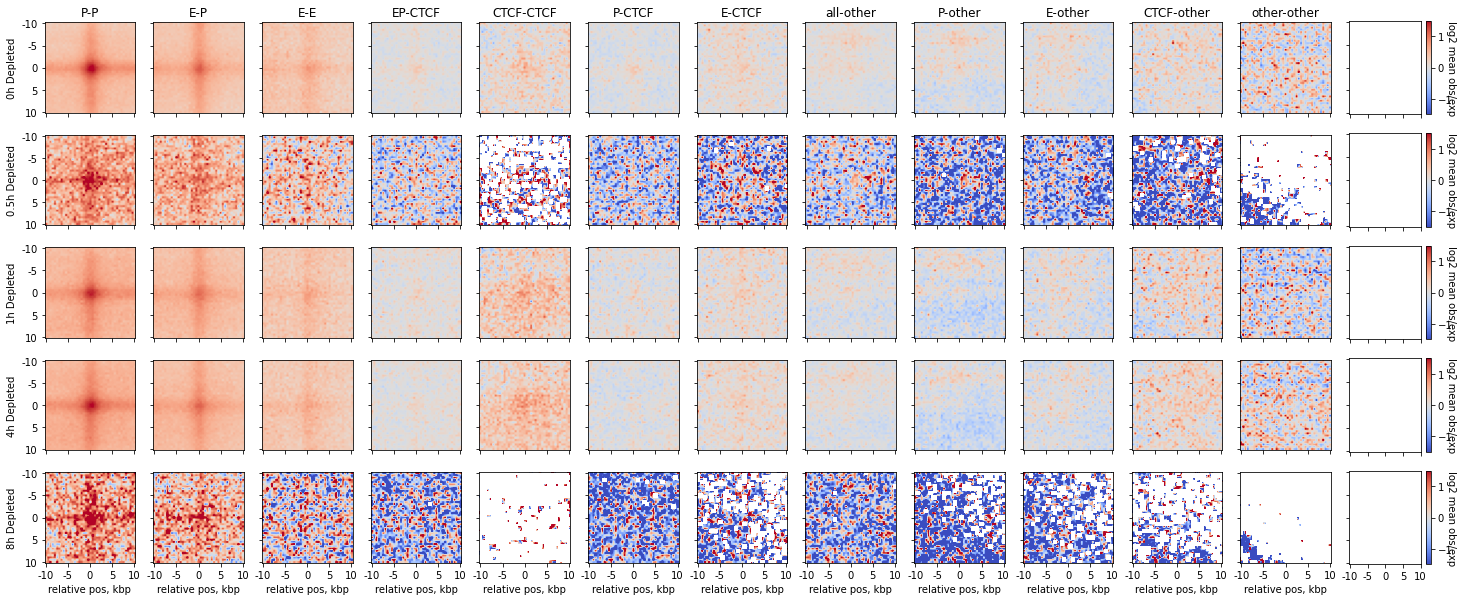

In [7]:
xTitles = loopTypesNames
yTitles = ['0h Depleted', '0.5h Depleted', '1h Depleted', '4h Depleted', '8h Depleted']
vMax = 1.5
vMin = -1.5

f, axs = plt.subplots(
    figsize=(25, 10),
    nrows=5,
    ncols=13,
    sharex=True,
    sharey=True
)

for i in range(5):
    for j in range(12):
        ax = axs[i,j]
        ax.imshow(
            np.log2(mtxsByConditionByType[i][j]),
            vmax = vMax,
            vmin = vMin,
            cmap='coolwarm')

ticks_pixels = np.linspace(0, flankDist * 2 // res, 5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1] / 2) * res // 1000).astype(int)

for i in range(5):
    ax = axs[i,0]
    ax.set_yticks(ticks_pixels, ticks_kbp)
    ax.set_ylabel(yTitles[i])
    cbar = plt.colorbar(axs[i,11].imshow(np.log2(mtxsByConditionByType[i][j]), vmax = vMax, vmin = vMin, cmap='coolwarm'), ax=axs[i, 12])
    cbar.set_label('log2 mean obs/exp', rotation=270)

for j in range(12):
    ax = axs[4,j]
    ax.set_xticks(ticks_pixels, ticks_kbp)
    ax.set_xlabel('relative pos, kbp')
    ax = axs[0,j]
    ax.set_title(xTitles[j])

f.savefig('SAVE_DIRECTORY/FILE_NAME.svg', dpi=1200)

plt.show()